---
# [GenericGLM](https://linescanning.readthedocs.io/en/latest/classes/glm.html#linescanning.glm.GenericGLM)

This page shows how to implement a simple GLM using the functions embedded in `linescanning.glm`. First, I show how to set up the GLM using the individual functions, which is way too annoying to remember everytime you want to run a glm. For that reason, there's also the `GenericGLM` class, which does everything the individual functions do but then in 1 line of code. Saves some time:). The experiment used in this example was a hemifield-stimulation experiment, so our event conditions are 'left' and 'right'.

In [1]:
%reload_ext autoreload
%autoreload 2

In [7]:
# imports
from linescanning import glm, utils, dataset, plotting
import warnings
import os
import matplotlib.pyplot as plt
import seaborn as sns

warnings.simplefilter('ignore')
opj = os.path.join

In [8]:
# define files
data_path = os.path.dirname(os.path.dirname(glm.__file__))
func_file = opj(data_path, 'examples', 'bold.mat')
exp_file = opj(data_path, 'examples', 'events.tsv')

plot_vox = 359

(2700, 720)


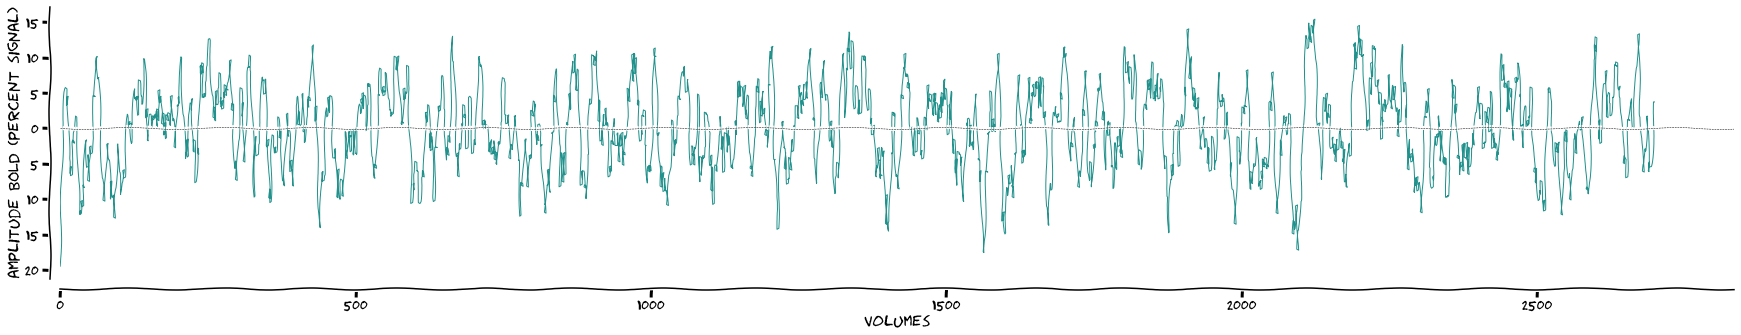

In [48]:
# load in functional data
window = 19
order = 3

data = dataset.Dataset(func_file,
                       subject=1,
                       run=1,
                       deleted_first_timepoints=100,
                       deleted_last_timepoints=0,
                       window_size=window,
                       high_pass=True,
                       poly_order=order,
                       tsv_file=exp_file,
                       use_bids=False)

# fetch percent signal change
func = data.fetch_fmri(strip_index=True) # > strip the dataframe from subject, run, t indices
print(func.shape)

# plot a timecourse
plotting.LazyPlot(func.values[:,plot_vox], 
                  font_size=16, 
                  set_xlim_zero=True,
                  sns_trim=False,                  
                  add_hline='default',
                  x_label="volumes", 
                  y_label="amplitude BOLD (percent signal)", 
                  xkcd=True)


Onset file is already read in by `Dataset` via `ParseExpToolsFile`; onset times have been corrected for deleted volumes

In [17]:
onsets = data.fetch_onsets()
onsets

,onset,event_type,subject,run
0,27.961789,right,1,1
1,32.903438,right,1,1
2,37.036976,right,1,1
3,38.811892,right,1,1
4,43.937109,right,1,1
...,...,...,...,...
74,282.608184,right,1,1
75,286.016544,left,1,1
76,289.266474,left,1,1
77,292.133307,right,1,1


Oversample with factor 1000 to get rid of 3 decimals in onset times. The larger this factor, the more accurate decimal onset times will be processed, but also the bigger your upsampled convolved becomes, which means convolving will take longer.

{'left': array([0., 0., 0., ..., 0., 0., 0.]),
 'right': array([0., 0., 0., ..., 0., 0., 0.])}

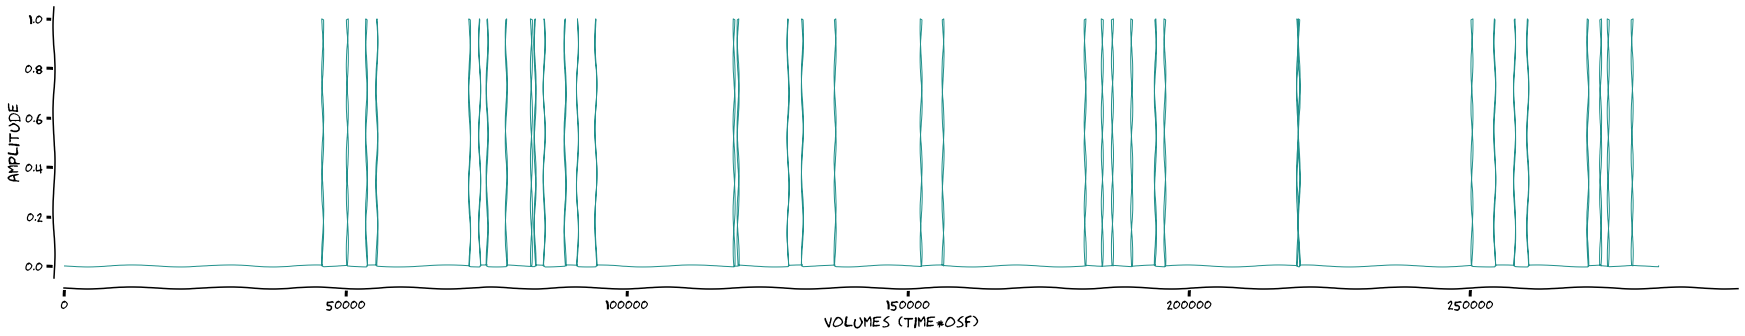

In [23]:
osf = 1000

# make stimulus vectors
stims = glm.make_stimulus_vector(onsets, scan_length=func.shape[0], osf=osf, type='event')
plotting.LazyPlot(stims['left'], 
                  font_size=16, 
                  x_label="volumes (time*osf)", 
                  set_xlim_zero=True,
                  sns_trim=False,
                  y_label="amplitude", 
                  xkcd=True)
stims

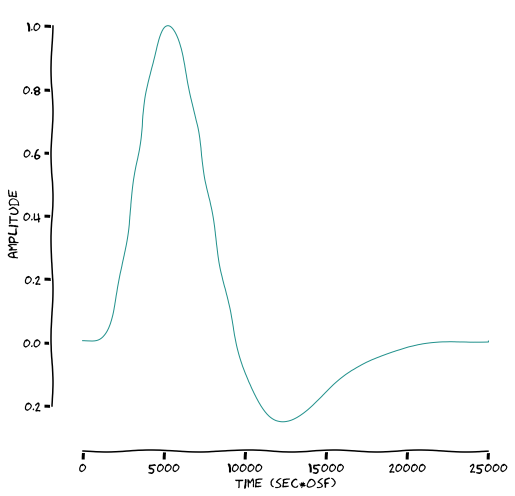

In [25]:
# define HRF
dt = 1/osf
time_points = np.linspace(0, 25, np.rint(float(25)/dt).astype(int))
hrf = glm.double_gamma(time_points, lag=6)
plotting.LazyPlot(hrf, 
                  figsize=(8,8), 
                  font_size=14, 
                  x_label="time (sec*osf)", 
                  y_label="amplitude", 
                  xkcd=True)


Convolve the stimulus vectors with the HRF. Because `stims` is a `dict`, the function will loop over the `keys` and as such, produce the outputs for all events. In this case, it's two events, namely `left` stimulation and `right` stimulation

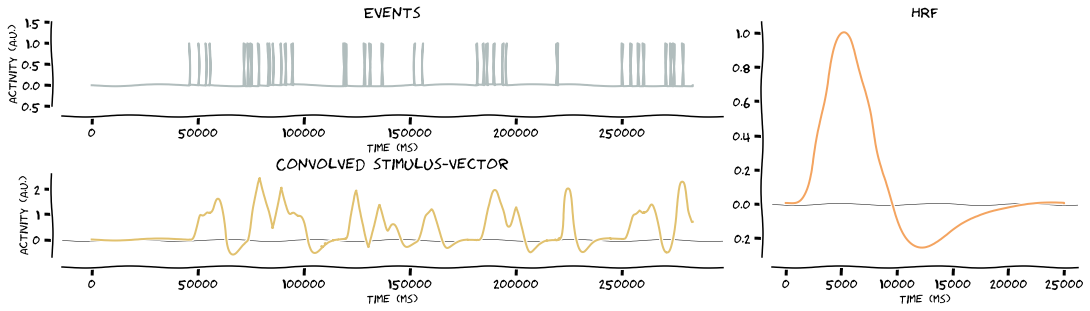

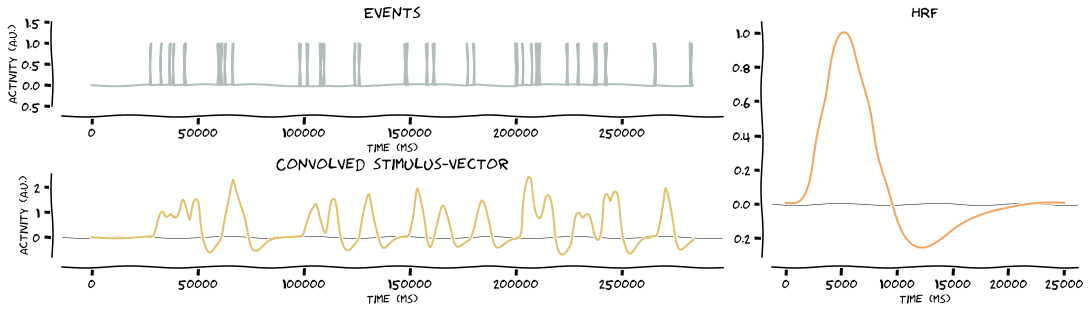

{'left': array([0.        , 0.        , 0.        , ..., 0.70500641, 0.70478048,
        0.70455449]),
 'right': array([ 0.        ,  0.        ,  0.        , ..., -0.0730913 ,
        -0.07300529, -0.07291914])}

In [26]:
# convolve stimulus vector with HRF
stim_vector = glm.convolve_hrf(hrf, stims, make_figure=True, xkcd=True)
stim_vector

In [50]:
# resample back to time domain of functional data
stim_vector_resampled = glm.resample_stim_vector(stim_vector, func.shape[0])
stim_vector_resampled


{'left': array([0.        , 0.        , 0.        , ..., 0.75053595, 0.72774167,
        0.70455449]),
 'right': array([ 0.        ,  0.        ,  0.        , ..., -0.0883798 ,
        -0.08117716, -0.07291914])}

In [51]:
# create design matrix without regressors
design_no_regressors = glm.first_level_matrix(stim_vector_resampled)
design_no_regressors

,intercept,left,right
0,1.0,0.000000,0.000000
1,1.0,0.000000,0.000000
2,1.0,0.000000,0.000000
3,1.0,0.000000,0.000000
4,1.0,0.000000,0.000000
...,...,...,...
2695,1.0,0.794522,-0.100938
2696,1.0,0.772771,-0.094854
2697,1.0,0.750536,-0.088380
2698,1.0,0.727742,-0.081177


In [52]:
# create some fake regressors
regressors = np.zeros((func.shape[0],5))
for ii in range(regressors.shape[-1]):
    regressors[...,ii] = utils.random_timeseries(1.2,(ii/8),func.shape[0])

In [53]:
# create design matrix with regressors
design_regressors = glm.first_level_matrix(stim_vector_resampled, regressors=regressors)
design_regressors


,intercept,left,right,regressor 0,regressor 1,regressor 2,regressor 3,regressor 4
0,1.0,0.000000,0.000000,1.2,1.200000,1.200000,1.200000,1.200000
1,1.0,0.000000,0.000000,1.2,1.085555,1.050038,0.235860,1.557244
2,1.0,0.000000,0.000000,1.2,1.257389,0.661390,0.374693,1.315997
3,1.0,0.000000,0.000000,1.2,1.301121,1.174645,1.227788,1.205225
4,1.0,0.000000,0.000000,1.2,1.234980,1.470239,1.673260,1.061264
...,...,...,...,...,...,...,...,...
2695,1.0,0.794522,-0.100938,1.2,-4.691272,0.763599,-13.733983,-6.704680
2696,1.0,0.772771,-0.094854,1.2,-4.829151,1.055957,-13.233286,-7.051270
2697,1.0,0.750536,-0.088380,1.2,-4.584611,0.993886,-12.537615,-8.333331
2698,1.0,0.727742,-0.081177,1.2,-4.523025,1.099402,-12.417957,-8.058149


max tstat (vox 404) = 6.28
max beta (vox 404) = 3.9
max tstat (vox 478) = 7.29
max beta (vox 478) = 0.28


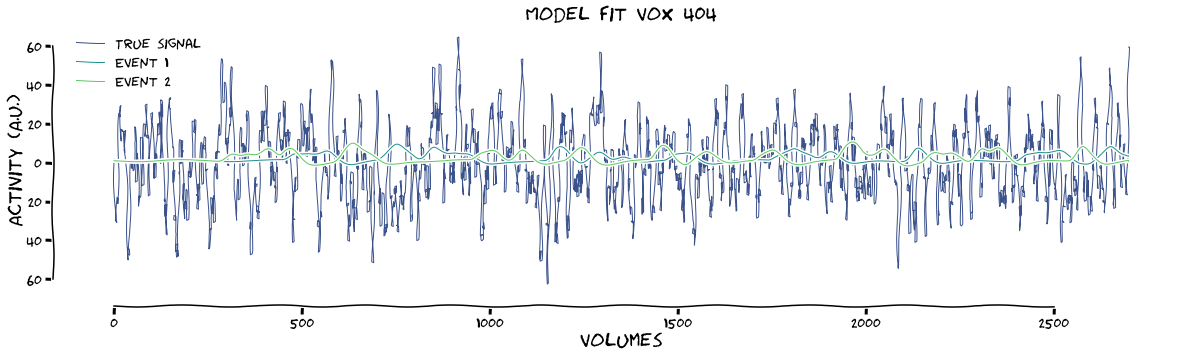

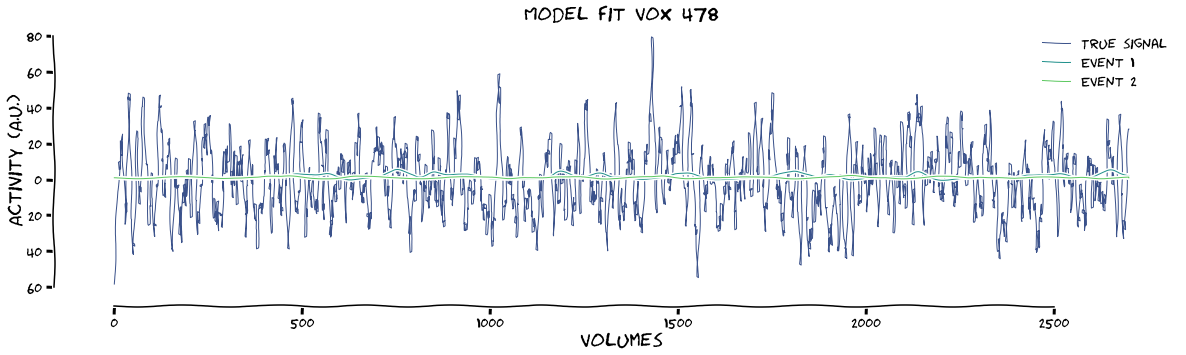

In [57]:
# fit design without regressors + plot first 2 events ('left' & 'right' stimulation)
results = glm.fit_first_level(design_no_regressors, func.values, make_figure=True, xkcd=True, plot_event=[1,2])

# fit design with regressors + plot first 2 events ('left' & 'right' stimulation)
results = glm.fit_first_level(design_regressors, func.values, make_figure=True, xkcd=True, plot_event=[1, 2])


The fact that the betas drop so much after including regressors shows that my fake regressors were really bad. To help with the data structure that comes out of this function, I've printed the shapes of the betas and the design matrix below:

In [58]:
print(f"betas have shape: {results['betas'].shape}")
print(f"design has shape: {results['x_conv'].shape}")

betas have shape: (8, 720)
design has shape: (2700, 8)


Now, we can do all of the above much easier with the `GenericGLM` class. First let's repeat the fitting without regressors

Creating stimulus vector(s)
Defining HRF
Convolve stimulus vectors with HRF


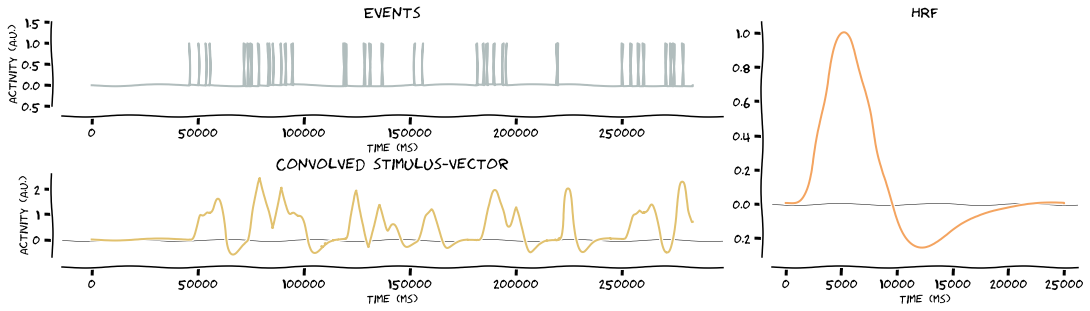

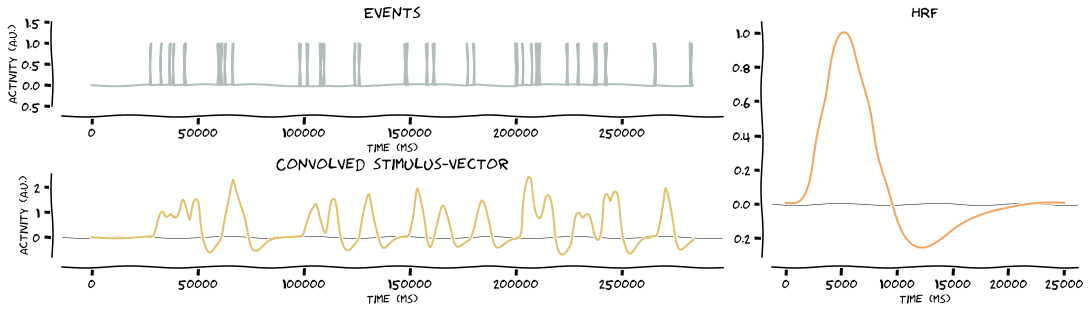

Resample convolved stimulus vectors
Creating design matrix
Running fit
max tstat (vox 404) = 6.28
max beta (vox 404) = 3.9


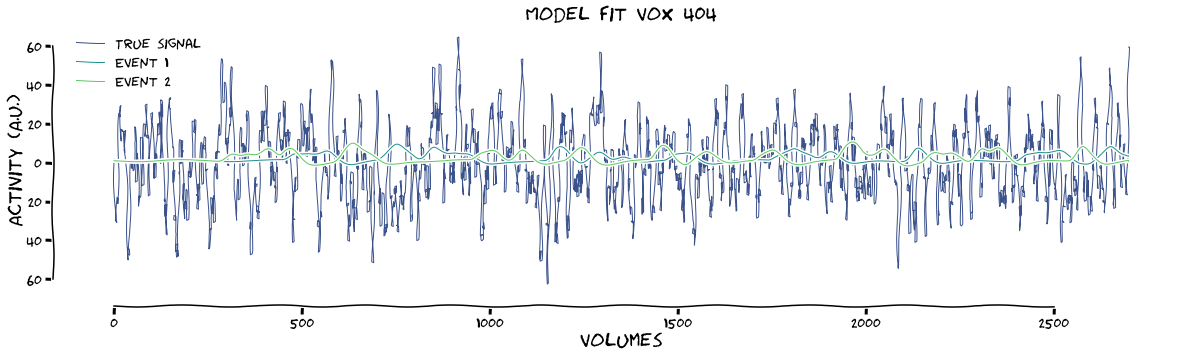

In [59]:
fitting = glm.GenericGLM(onsets, func.values, TR=data.TR, osf=1000, make_figure=True, xkcd=True, verbose=True, plot_event=[1,2])

And the design *with* regressors

Creating stimulus vector(s)
Defining HRF
Convolve stimulus vectors with HRF


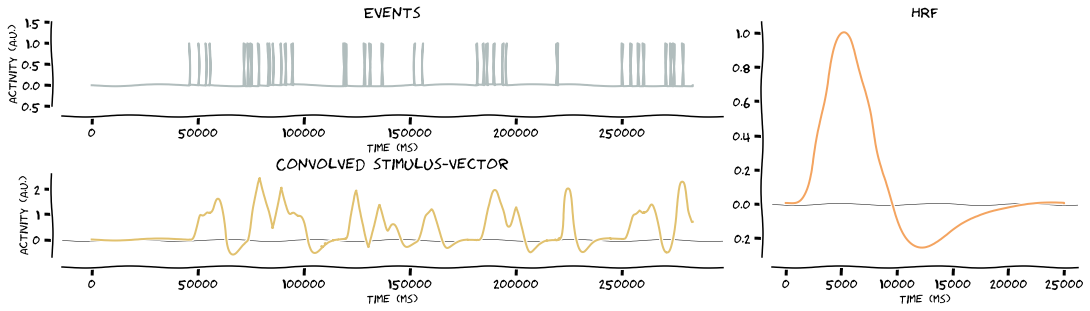

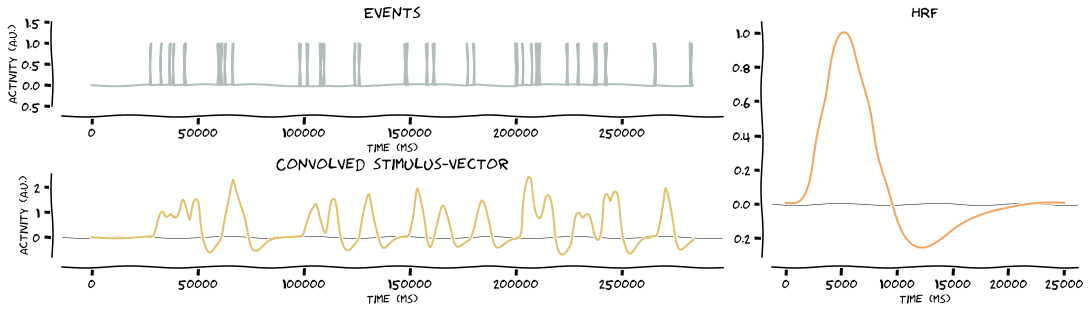

Resample convolved stimulus vectors
Creating design matrix
Running fit
max tstat (vox 478) = 7.29
max beta (vox 478) = 0.28


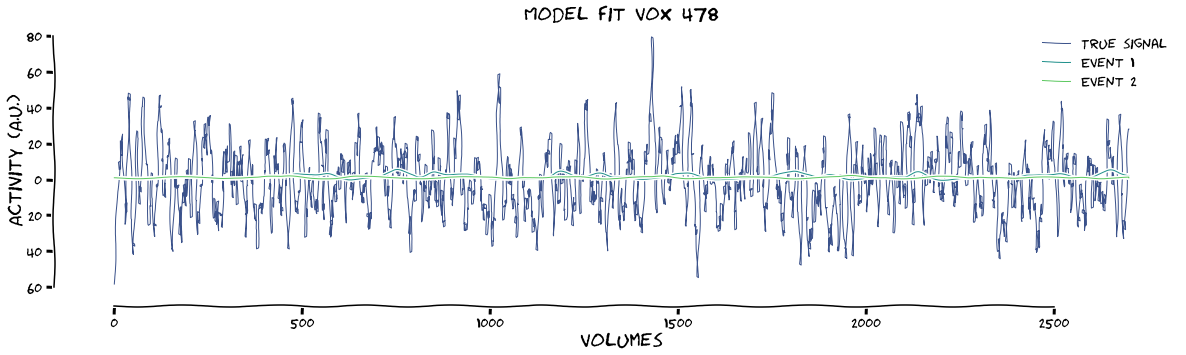

In [60]:
fitting = glm.GenericGLM(onsets, func.values, TR=data.TR, osf=1000, regressors=regressors, make_figure=True, xkcd=True, verbose=True, plot_event=[1,2])

In [74]:
print("betas have shape: {}".format(fitting.results["betas"].shape))
print("design have shape: {}".format(fitting.results["x_conv"].shape))


betas have shape: (8, 720)
design have shape: (2700, 8)


But the shortest way is without producing plots. Just give it the onset times `onsets`, the fMRI-data `data` (either in np.ndarray form or pd.DataFrame), the `TR` (which can be reproduced from `ParseFuncFile`-object), the oversampling factor `osf`, and `regressors` (either in np.ndarray form or pd.DataFrame). Even these final 2 items (oversampling & regressors) are NOT mandatory options. They will, generally, make your analysis more accurate! Below we do the same fitting, without regressors, but we do want the information for voxel `359` for consistency sake.

In [75]:
fitting = glm.GenericGLM(onsets, func.values, TR=data.TR, osf=1000)

max tstat (vox 404) = 6.28
max beta (vox 404) = 3.9


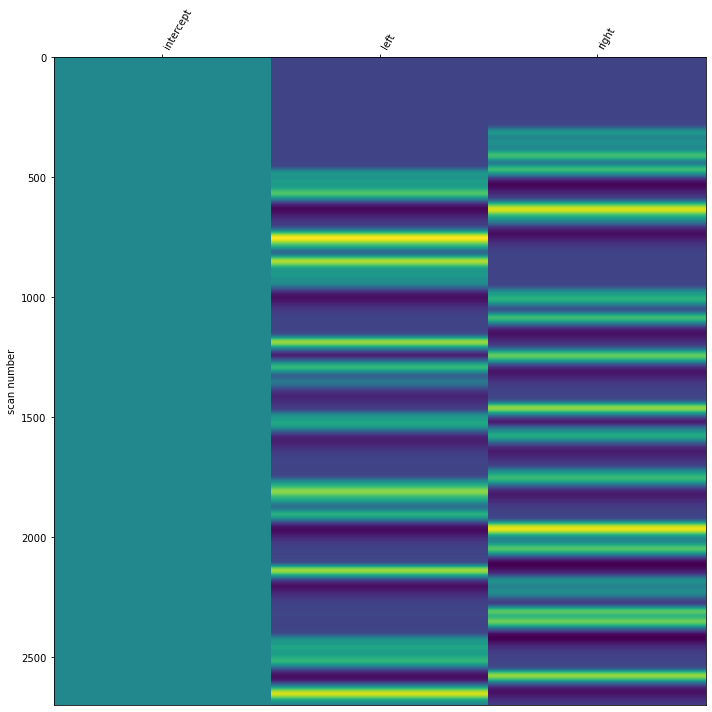

In [77]:
fitting.plot_design_matrix()